In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.quantum_info import SparsePauliOp

from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler, Estimator

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Method to construct the Convolutional Layer for the QCNN
def conv_layer(qc:QuantumCircuit(), para:ParameterVector, iter:int) -> QuantumCircuit():
    start = 0 if qc.num_qubits == 2 else -1
    iter = 3 if iter == 0 else iter
    for i in range(start, qc.num_qubits-1):
        qc.rz(-np.pi / 2, i+1)
        qc.cx(i+1, i)
        qc.rz(para[(3*i)+iter], i)
        qc.ry(para[(3*i)+1+iter], i+1)
        qc.cx(i, i+1)
        qc.ry(para[(3*i)+2+iter], i+1)
        qc.cx(i+1, i)
        qc.rz(np.pi / 2, i)
        qc.barrier()
    if iter == 3:
        iter = 0
    if qc.num_qubits == 2:
        iter += 3
    else: 
        iter += (3*(qc.num_qubits)) 
    return qc, iter

# Method to construct the Pooling Layer for the QCNN
def pool_layer(qc:QuantumCircuit(), para:ParameterVector, iter:int) -> QuantumCircuit():
    half = int(qc.num_qubits/2)
    for i in range(half):
        qc.rz(-np.pi / 2, i+half)
        qc.cx(i+half, i)
        qc.rz(para[(3*i)+iter], i)
        qc.ry(para[(3*i)+1+iter], i+half)
        qc.cx(i, i+half)
        qc.ry(para[(3*i)+2+iter], i+half)
        qc.barrier()
    iter += (half*3)
    return qc, iter

# Method that builds the entire circuit and layers systematically
def qcnn_circuit(num_qubits:int, num_outputs:int) -> QuantumCircuit():
    qc = QuantumCircuit(num_qubits)
    num_outputs *= 2
    num_layers = np.log2(num_qubits) # Calculates number of convolutional/pooling layers
    
    feature_map = ZFeatureMap(num_qubits)  # Pulls in Qiskit's built in ZFeatureMap
    qc.compose(feature_map, range(num_qubits), inplace=True) # Adds ZFeatureMap to circuit for initialization
    
    parameter_vec = ParameterVector(name="θ", length=int(9*(2**num_layers))-12) # Calculates number of parameters needed
   
    iter = 0 # Tracks where in the Parameter Vector to put the next parameter
    index = num_qubits # Divides itself in half at each layer
    layer = 1 # Tracks the current layer being constructed
    while index > int(num_outputs): # Adds 1 convolution layer and 1 pooling layer then iterates until the desired amount of outputs remain
        conv_qc = QuantumCircuit(index)
        pool_qc = QuantumCircuit(index)
        
        # Adds 1 convolutional layer to the circuit by converting the convolutional circuit to a gate
        conv_qc, iter = conv_layer(conv_qc, parameter_vec, iter)
        qc.compose(conv_qc.to_instruction(label=f'Convolution Layer {layer}'), range(int(num_qubits - index), num_qubits), inplace=True)
        
        # Adds 1 pooling layer to the circuit by converting the pooling circuit to a gate
        pool_qc, iter = pool_layer(pool_qc, parameter_vec, iter)
        qc.compose(pool_qc.to_instruction(label=f'Pooling Layer {layer}'), range(int(num_qubits - index), num_qubits), inplace=True)

        # Handle tracker increment or decrement
        index = int(index / 2)
        layer += 1

    # Constructs weight parameter by removing ZFeatureMap's parameters from the total
    weight_params = qc.parameters - feature_map.parameters
    return qc, feature_map.parameters, weight_params


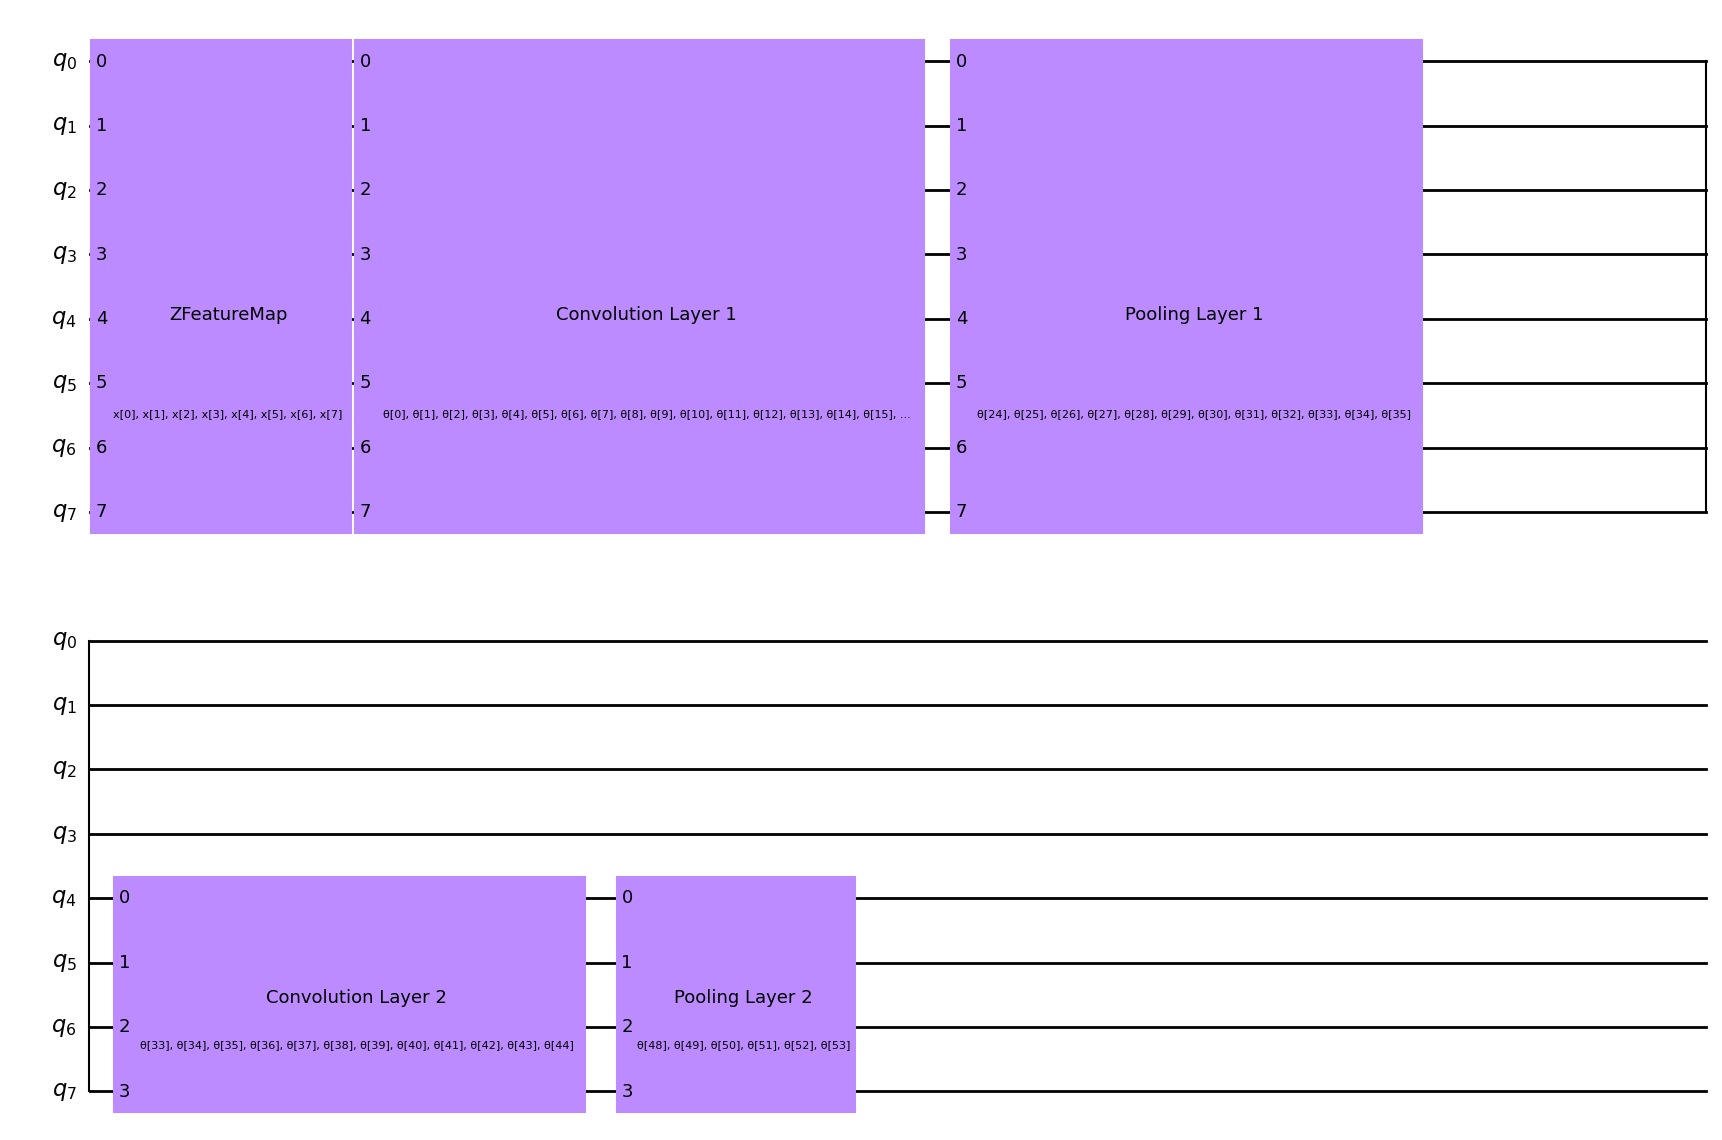

In [4]:
""" PERSONAL NOTES
2 qubits = 6 parameters
4 qubits = 24 parameters
8 qubtes = 60 parameters
observables=SparsePauliOp.from_list([("Z" + "I" * 7, 1)])
"""

# Declares the Quantum Convolutional Circuit and extracts the input and weigh parameters from the qcnn_circuit method
qcnn, input_params, weight_params = qcnn_circuit(8, 1)

qcnn_est = EstimatorQNN(circuit=qcnn.decompose(), input_params=input_params, weight_params=weight_params)
qcnn.draw("mpl", style="clifford")

In [7]:
# To plot the progress of the circuits learning
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## QCNN Binary Classification

In [9]:
# Declares Classifier
classifier = NeuralNetworkClassifier(
    qcnn_est,
    optimizer=COBYLA(maxiter=500),  # Set max iterations here
    #callback=callback_graph,
    #initial_point=initial_point,
)

In [25]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 3)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels


images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=246)

x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []

plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

In [34]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

ValueError: Found input variables with inconsistent numbers of samples: [14, 13]

## QCNN multi-class?

In [14]:
in_qubits, out_qubits = 8, 2
qcnn2, input_params2, weight_params2 = qcnn_circuit(in_qubits, out_qubits)

def func(x):
    return x % 2**out_qubits # Mod amount must match out_qubits

qcnn_est2 = SamplerQNN(circuit=qcnn.decompose(),
                       input_params=input_params, weight_params=weight_params,
                       interpret=func, output_shape=(2**out_qubits))
classifier2 = NeuralNetworkClassifier(qcnn_est2, optimizer=COBYLA(maxiter=10000))
print(qcnn_est2.output_shape)

twoDarray = [np.array([0, 0, 0, 0, 0, 0, 0, 0]),
             np.array([1, 0, 0, 0, 0, 0, 0, 0]),
             np.array([1, 1, 0, 0, 0, 0, 0, 0]),
             np.array([1, 1, 1, 0, 0, 0, 0, 0]),
             np.array([1, 1, 1, 1, 0, 0, 0, 0]),
             np.array([1, 1, 1, 1, 1, 0, 0, 0]),
             np.array([1, 1, 1, 1, 1, 1, 0, 0]),
             np.array([1, 1, 1, 1, 1, 1, 1, 0]),
             np.array([0, 0, 0, 0, 0, 0, 0, 0]), #even
             np.array([0, 0, 1, 0, 0, 0, 0, 0]),
             np.array([0, 1, 0, 1, 0, 0, 0, 0]),
             np.array([0, 1, 1, 0, 1, 0, 0, 0]),
             np.array([1, 0, 1, 1, 0, 1, 0, 0]),
             np.array([1, 1, 1, 0, 1, 0, 1, 0]),
             np.array([1, 1, 0, 1, 1, 1, 0, 1]),
             np.array([1, 1, 1, 1, 1, 0, 1, 1])]
twoDarrayAns = [.2, .3, .5, .3, .5, .3, .5, .3, .5, .3, .5, .3, .5, .3, .5, .3]

trainer, tester, trainer_ans, tester_ans = train_test_split(twoDarray, twoDarrayAns, test_size=0.25, random_state=246)

x2 = np.asarray(trainer)
y2 = np.asarray(trainer_ans)

objective_func_vals2 = []

plt.rcParams["figure.figsize"] = (12, 6)

(4,)


In [15]:
classifier2.fit(x2, y2)

In [16]:
y_predict = classifier2.predict(tester)
xg = np.asarray(tester)
yg = np.asarray(tester_ans)

print(xg)
print(yg)
print(y_predict)
#print(f"Accuracy from the test data : {np.round(100 * classifier2.score(xg, yg), 2)}%")

[[1 1 1 1 1 1 0 0]
 [1 1 1 1 1 0 0 0]
 [1 1 1 0 1 0 1 0]
 [0 1 1 0 1 0 0 0]]
[0.5 0.3 0.3 0.3]
[0 0 2 0]


In [46]:
def parity(x):
    return f"{bin(x)}".count("1") % 2

for i in range(10):
    print(f'{i} maps to {parity(i)}')

0 maps to 0
1 maps to 1
2 maps to 1
3 maps to 0
4 maps to 1
5 maps to 0
6 maps to 0
7 maps to 1
8 maps to 1
9 maps to 0
